In [2]:
using DataFrames, LogTopReg, Distributions

In [46]:
K = 2;
σ_μ = 0.1;
σ_A = sqrt(0.8);
σ = sqrt(0.2);
σ_β = 0.0;

n = 200;
p = 2;
nd = repeat([50],inner=[n]);
A = rand(InverseWishart(n+1,eye(n)));
A = A./(sqrt(diag(A))*sqrt(diag(A))');
UA = chol(A);
y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ;
β = randn(K,p)*σ_β;
X = randn(p,n);
g = randn(K,n)*UA;

In [47]:
θ = linspace(0.1,K*2,K).^2;
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ + β*X[:,i] + σ_A.*g[:,i];
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hcat(map(j -> hcat(rand(Poisson(θ[j]),nk[j,i]),rand(Poisson(θ[K:-1:1][j]),nk[j,i]))', 1:K)...);
end

In [48]:
pss0 = VectorPosterior(PoissonPosterior(0.1,0.1),2);
niter = 1000;
thin = 1;
ns = div(niter,thin);
hyper = hyperparameter(τ0_u = 0.01,ν0_u=0.33,ν0_σ2η=0.01,σ0_σ2η = 0.01,τ0_τ = 0.01,ν0_τ = 0.01,τ_β = 0.75);

In [49]:
@time fit = topiclmm(y,X,convert(Array{Float64,2},UA),pss0,K,hyper,iter=niter,thin=thin);

 50.976034 seconds (351.95 M allocations: 27.315 GB, 7.08% gc time)


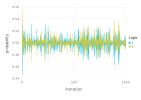

In [51]:
using Gadfly
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

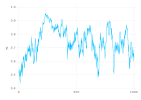

In [52]:
σ2Ahat = fit[:τ_u][2,:].*fit[:σ2][2,:]+fit[:τ_u][1,:].*fit[:σ2][1,:];
σ2hat = fit[:σ2][2,:] + fit[:σ2][1,:];
h2 = σ2Ahat./(σ2hat.+σ2Ahat)

plot(y=h2,Geom.line)

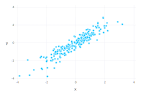

In [39]:
plot(y=η[1,:]-η[2,:].-μ[1].+μ[2],x=fit[:η][1,:,500] - fit[:η][2,:,500] .- fit[:μ][1,500] .+ fit[:μ][2,500])

In [21]:
resid1 = fit[:η][1,:,500] .- X'*fit[:β][:,1,500] .- fit[:μ][1,500] .- UA'*fit[:u][:,1,500];
resid2 = fit[:η][2,:,500] .- X'*fit[:β][:,2,500] .- fit[:μ][2,500] .- UA'*fit[:u][:,2,500];
var(resid1-resid2)

1.3877846598863555

In [322]:
size(fit[:σ2])

(2,500)

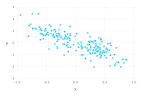

In [22]:
plot(x=mean( (UA'*fit[:u][:,1,:]-UA'*fit[:u][:,2,:])[:,101:500] ,2),y=g[1,:]-g[2,:],Geom.point)